<a href="https://colab.research.google.com/github/federicocampo/CNN_prova/blob/main/Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
from matplotlib import pyplot as plt
from skimage.io import imread, imshow
from skimage import img_as_float
from skimage.restoration import denoise_wavelet
from PIL import Image
import pywt
import os
import glob
import numpy as np
import logging
import time

In [6]:
PATH = 'gdrive/MyDrive/IMAGES/Mammography_micro'

In [96]:
def twolvldenoiseddwt(myim, wavelet):
    """ This function decompose the original image with a Discrete Wavelet Transformation
        using the desired wavelet family up to the third level. It keeps all the details
        coefficient and mask the resulted approximated image in order to enhance the
        visibility of all the details.
    """
    myim = img_as_float(myim)
    myim_denoised = denoise_wavelet(myim, method='BayesShrink', mode='soft', rescale_sigma='True')

    level = 2
    # mode = 'periodization' 

    # Here I get my approximated image and the relative coefficients
    cA, (cH2, cV2, cD2), (cH1, cV1, cD1) = pywt.wavedec2(myim_denoised, wavelet, level=level)

    """ Now, I get the standard deviation for each matrix (image and coefficients).
        The std will act as a treshold so that if abs(value) < 0. --> value = 0.
                                             elif abs(value) > 0. --> value = value
    """ 
    mult_val = 1.

    ncA = np.zeros_like(cA)

    std10 = np.std(cH1)*mult_val
    std11 = np.std(cV1)*mult_val
    std12 = np.std(cD1)*mult_val

    ncH1 = pywt.threshold(cH1, std10, mode = 'hard', substitute = 0.)
    ncV1 = pywt.threshold(cV1, std11, mode = 'hard', substitute = 0.)
    ncD1 = pywt.threshold(cD1, std12, mode = 'hard', substitute = 0.)

    std20 = np.std(cH2)*mult_val
    std21 = np.std(cV2)*mult_val
    std22 = np.std(cD2)*mult_val

    ncH2 = pywt.threshold(cH2, std20, mode = 'hard', substitute = 0.)
    ncV2 = pywt.threshold(cV2, std21, mode = 'hard', substitute = 0.)
    ncD2 = pywt.threshold(cD2, std22, mode = 'hard', substitute = 0.)

    """ To let things be more readable I define new_coeff,
        this is just so that waverec2 (the function needed to reconstruct
        the image from a set of given coefficient) can do what it does.
    """

    new_coeff = ncA, (ncH2, ncV2, ncD2), (ncH1, ncV1, ncD1) 

    mynewim = pywt.waverec2(new_coeff, wavelet)
    mynewim = pywt.threshold(mynewim, 0., mode = 'greater', substitute = 0.)

    return mynewim

In [4]:
def threelvldenoiseddwt(myim, wavelet):
    """ This function decompose the original image with a Discrete Wavelet Transformation
        using the desired wavelet family up to the third level. It keeps all the details
        coefficient and mask the resulted approximated image in order to enhance the
        visibility of all the details.
    """
    myim = img_as_float(myim)
    myim_denoised = denoise_wavelet(myim, method='BayesShrink', mode='soft', rescale_sigma='True')

    level = 3
    # mode = 'periodization' 

    # Here I get my approximated image and the relative coefficients
    cA, (cH3, cV3, cD3), (cH2, cV2, cD2), (cH1, cV1, cD1) = pywt.wavedec2(myim_denoised, wavelet, level=level)

    """ Now, I get the standard deviation for each matrix (image and coefficients).
        The std will act as a treshold so that if abs(value) < 0. --> value = 0.
                                             elif abs(value) > 0. --> value = value
    """ 
    mult_val = 1.

    ncA = np.zeros_like(cA)

    std10 = np.std(cH1)*mult_val
    std11 = np.std(cV1)*mult_val
    std12 = np.std(cD1)*mult_val

    ncH1 = pywt.threshold(cH1, std10, mode = 'hard', substitute = 0.)
    ncV1 = pywt.threshold(cV1, std11, mode = 'hard', substitute = 0.)
    ncD1 = pywt.threshold(cD1, std12, mode = 'hard', substitute = 0.)

    std20 = np.std(cH2)*mult_val
    std21 = np.std(cV2)*mult_val
    std22 = np.std(cD2)*mult_val

    ncH2 = pywt.threshold(cH2, std20, mode = 'hard', substitute = 0.)
    ncV2 = pywt.threshold(cV2, std21, mode = 'hard', substitute = 0.)
    ncD2 = pywt.threshold(cD2, std22, mode = 'hard', substitute = 0.)
    
    std30 = np.std(cH3)*mult_val
    std31 = np.std(cV3)*mult_val
    std32 = np.std(cD3)*mult_val

    ncH3 = pywt.threshold(cH3, std30, mode = 'hard', substitute = 0.)
    ncV3 = pywt.threshold(cV3, std31, mode = 'hard', substitute = 0.)
    ncD3 = pywt.threshold(cD3, std32, mode = 'hard', substitute = 0.)

    """ To let things be more readable I define new_coeff,
        this is just so that waverec2 (the function needed to reconstruct
        the image from a set of given coefficient) can do what it does.
    """

    new_coeff = ncA, (ncH3, ncV3, ncD3), (ncH2, ncV2, ncD2), (ncH1, ncV1, ncD1) 

    mynewim = pywt.waverec2(new_coeff, wavelet)
    mynewim = pywt.threshold(mynewim, 0., mode = 'greater', substitute = 0.)

    return mynewim

I've run the fit on original dataset just for trying

In [15]:
import multiprocessing as mp

def parallel_open_img(image_path):
  fnames = glob.glob(os.path.join(image_path, '*.pgm'))

  pool = mp.Pool(processes=4)
  images_mp = pool.map_async(Image.open, fnames)

  images = images_mp.get()

  print(f'Number of images found = {len(images)}')
  return images

start_time = time.time()

labels = []

image_path = os.path.join(PATH, 'Train/0')
print('Reading Train Images with label 0:')
images_0_train = parallel_open_img(image_path)

processed_images_0_train = []
for i, image in enumerate(images_0_train):
  processedimage = threelvldenoiseddwt(image, 'sym2')
  processed_images_0_train.append(processedimage)

processed_images_0_train = np.array(processed_images_0_train, dtype='float32')[..., np.newaxis]/255
labels += len(processed_images_0_train)*[0]
print(f'Number of images processed = {len(processed_images_0_train)}')

image_path = os.path.join(PATH, 'Train/1')
print('\nReading Train Images with label 1:')
images_1_train = parallel_open_img(image_path)

processed_images_1_train = []
for i, image in enumerate(images_1_train):
  processedimage = threelvldenoiseddwt(image, 'sym2')
  processed_images_1_train.append(processedimage)

processed_images_1_train = np.array(processed_images_1_train, dtype='float32')[..., np.newaxis]/255
labels += len(processed_images_1_train)*[1]
print(f'Number of images processed = {len(processed_images_1_train)}')

x_train_processed = np.concatenate((processed_images_0_train, processed_images_1_train), axis = 0)
y_train_processed = np.array(labels)

print(f'\nx_train_processed shape = {x_train_processed.shape} <-- (number of images, width, height)\n')



labels = []

image_path = os.path.join(PATH, 'Test/0')
print('Reading Test Images with label 0:')
images_0_test = parallel_open_img(image_path)

processed_images_0_test = []
for i, image in enumerate(images_0_test):
  processedimage = threelvldenoiseddwt(image, 'sym2')
  processed_images_0_test.append(processedimage)

processed_images_0_test = np.array(processed_images_0_test, dtype='float32')[..., np.newaxis]/255
labels += len(processed_images_0_test)*[0]
print(f'Number of images processed = {len(processed_images_0_test)}')

image_path = os.path.join(PATH, 'Test/1')
print('\nReading Test Images with label 1:')
images_1_test = parallel_open_img(image_path)

processed_images_1_test = []
for i, image in enumerate(images_1_test):
  processedimage = threelvldenoiseddwt(image, 'sym2')
  processed_images_1_test.append(processedimage)

processed_images_1_test = np.array(processed_images_1_test, dtype='float32')[..., np.newaxis]/255
labels += len(processed_images_1_test)*[1]
print(f'Number of images processed = {len(processed_images_1_test)}')

x_test_processed = np.concatenate((processed_images_0_test, processed_images_1_test), axis = 0)
y_test_processed = np.array(labels)

print(f'\nx_test_processed shape = {x_test_processed.shape} <-- (number of images, width, height)\n')

Reading Train Images with label 0:
Number of images found = 209
Number of images processed = 209

Reading Train Images with label 1:
Number of images found = 187
Number of images processed = 187

x_train_processed shape = (396, 60, 60, 1) <-- (number of images, width, height)

Reading Test Images with label 0:
Number of images found = 205
Number of images processed = 205

Reading Test Images with label 1:
Number of images found = 196
Number of images processed = 196

x_test_processed shape = (401, 60, 60, 1) <-- (number of images, width, height)



In [10]:
import multiprocessing as mp

def parallel_read_img(image_path):
  fnames = glob.glob(os.path.join(image_path, '*.pgm'))

  pool = mp.Pool(processes=4)
  results = pool.map_async(imread, fnames)

  x = results.get()
  x_np = np.array(x, dtype='float32')[..., np.newaxis]/255

  print(f'Number of images found = {len(x_np)}')
  return x_np


start_time = time.time()

labels = []

image_path = os.path.join(PATH, 'Train/0')
print('Reading Train Images with label 0:')
x0_train = parallel_read_img(image_path)
labels += len(x0_train)*[0]

image_path = os.path.join(PATH, 'Train/1')
print('\nReading Train Images with label 1:')
x1_train = parallel_read_img(image_path)
labels += len(x1_train)*[1]

x_train = np.concatenate((x0_train, x1_train), axis = 0)
y_train = np.array(labels)

print(f'\nx_train shape = {x_train.shape} <-- (number of images, width, height, depth)\n')


labels = []

image_path = os.path.join(PATH, 'Test/0')
print('\nReading Test Images with label 0:')
x0_test = parallel_read_img(image_path)
labels += len(x0_test)*[0]

image_path = os.path.join(PATH, 'Test/1')
print('\nReading Test Images with label 1:')
x1_test = parallel_read_img(image_path)
labels += len(x1_test)*[1]

x_test = np.concatenate((x0_test, x1_test), axis = 0)
y_test = np.array(labels)

print(f'\nx_test shape = {x_test.shape} <-- (number of images, width, height, depth)')

elapsed_time = time.time() - start_time
logging.info(f'Elapsed time = {elapsed_time} seconds')

Reading Train Images with label 0:
Number of images found = 209

Reading Train Images with label 1:
Number of images found = 187

x_train shape = (396, 60, 60, 1) <-- (number of images, width, height, depth)


Reading Test Images with label 0:
Number of images found = 205

Reading Test Images with label 1:
Number of images found = 196

x_test shape = (401, 60, 60, 1) <-- (number of images, width, height, depth)


In [11]:
from keras.layers import Dense, Flatten, BatchNormalization
from keras.models import Sequential

# Defining the model

In [12]:
model = Sequential([
    Flatten(), 
    Dense(102,  activation = 'relu'), 
    BatchNormalization(),
    Dense(32, activation = 'relu'), 
    BatchNormalization(),

    Dense(1, activation = 'sigmoid')
])

Compile and train

In [13]:
from keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate = 0.0005),
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

history = model.fit(
    x_train, y_train,
    validation_split = 0.25, 
    epochs=50,
)

Epoch 1/50
10/10 [==============================] - 2s 53ms/step - loss: 0.7016 - binary_accuracy: 0.6339 - val_loss: 0.1202 - val_binary_accuracy: 1.0000
Epoch 2/50
10/10 [==============================] - 0s 9ms/step - loss: 0.6481 - binary_accuracy: 0.6197 - val_loss: 0.1766 - val_binary_accuracy: 1.0000
Epoch 3/50
10/10 [==============================] - 0s 10ms/step - loss: 0.6011 - binary_accuracy: 0.6532 - val_loss: 0.1687 - val_binary_accuracy: 1.0000
Epoch 4/50
10/10 [==============================] - 0s 9ms/step - loss: 0.5147 - binary_accuracy: 0.6888 - val_loss: 0.1512 - val_binary_accuracy: 1.0000
Epoch 5/50
10/10 [==============================] - 0s 10ms/step - loss: 0.5371 - binary_accuracy: 0.6823 - val_loss: 0.1707 - val_binary_accuracy: 1.0000
Epoch 6/50
10/10 [==============================] - 0s 10ms/step - loss: 0.4864 - binary_accuracy: 0.7446 - val_loss: 0.2330 - val_binary_accuracy: 1.0000
Epoch 7/50
10/10 [==============================] - 0s 11ms/step - loss:

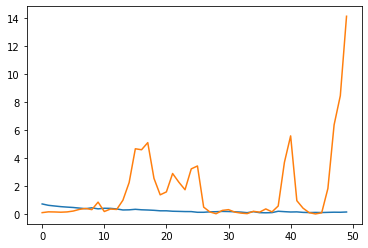

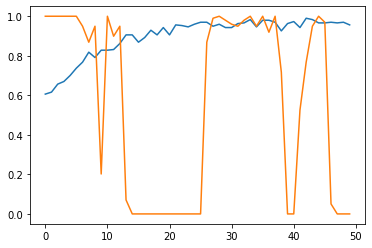

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.show()